In [1]:
%matplotlib notebook

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from natsort import natsorted
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy import stats
import statsmodels.api as sm
import pandas as pd
from scipy.signal import savgol_filter

# to import package in parent folder first add the parent folder to path
import sys
import os
packages_path = Path(os.path.dirname(os.path.realpath('__file__'))).parent
sys.path.insert(0, str(packages_path))


In [3]:
home_path = os.getcwd()

filepath = Path(home_path, 'Fig4_data')
savepath = Path(home_path, 'plots')

Path(savepath).mkdir(parents=True, exist_ok=True) 

In [4]:
filename = 'Fig4_CDE'
# read the numpy array
data = np.load(Path(filepath, filename + '.npy'))
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)

This numpy array contains the data to create Figure 4C, D and E. 
These plots show that decreasing light intensity from 73uW/mm2 
down to 8uW/mm2 helps with the interpretation of calcium imaging data.
The stimulus duration is 1 second and the stimulus wavelength 590nm. 

Output data is organized the following way:

1st dimension is 600. These are the datapoints 

2nd dimension is 7. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5. 
Each df/f is a repeat on the same animal 

3rd dimension is 5, one for each animal 

4th dimension is 3. These are: 8uW/mm2, 47uW/mm2 and 72uW/mm2 

5th dimension is 3. The first contains Gal4+, ATR- data, the second contains Gal4+, ATR+ data
the third contains Gal4-, ATR+

As and example, if one wants to grab Gal4+, ATR+, 8uW/mm2 data the indeces are: 
data[:, 2::,:,0,1].



<IPython.core.display.Javascript object>


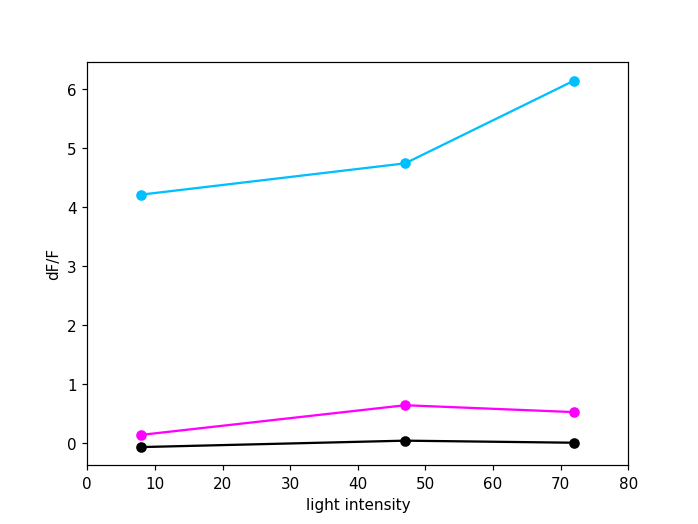

In [6]:
light_intensities = [8,
                     47, 
                     72
                    ]

fig = plt.figure()
ax = fig.add_subplot(111)

start_stim = np.where(data[:,1,0,0,0] > 0.2)[0][0]
stop_stim = np.where(data[:,1,0,0,0] > 0.2)[0][-1]
sample_rate = 1/data[1,0,0,0,0] # ~ 30 Hz

# We take 500ms before and 500ms after the STOP of the stimulus
time_to_take = 0.5  # in seconds
take_start = int(round(stop_stim - sample_rate * time_to_take))
take_end = int(round(stop_stim + sample_rate * time_to_take))
# And define indeces for the data to be taken before the stimulus starts!
take_before_start = int(round(start_stim - (sample_rate * time_to_take * 1)))
take_before_end = int(round(start_stim))

 
def extract_dF_F(data, current_condition):
    subtracted_dF_F = []
    for current_light_intensity in range(len(light_intensities)):

        before_median = np.median(data[take_before_start:take_before_end,2::, :, current_light_intensity, 
                                       current_condition])
        after_median = np.median(data[take_start:take_end,2::, :, current_light_intensity, 
                                      current_condition])

        subtracted_dF_F.append(after_median-before_median)
    
    return(subtracted_dF_F)

def plot_condition(data, condition, color):
    current_dF_F = extract_dF_F(data, condition)
    
    ax.scatter(x=light_intensities, y=current_dF_F, color=color)#, marker=marker)
    ax.plot(light_intensities, current_dF_F, color=color)#, alpha=alpha, label=label, linestyle=ls,lw=lw)


plot_condition(data,1, color='deepskyblue')
plot_condition(data,2, color='magenta')
plot_condition(data,0, color='k')

ax.set_xlim(0,80)
ax.set_ylabel('dF/F')
ax.set_xlabel('light intensity')
fig.savefig(Path(savepath, 'Fig4_C.svg'))